# Blog Post: Deep Music Genre Classification
Well, I've been hoping to do a deep learning blog post all semester, so I'm really excited to give this one a shot! The first step will be to properly format the data, and then perform text vectorization, since lyrics are words, which cannot function as features. Then, I will collate batches. Finally, I will be prepared to create a model and evaluate its accuracy. I will create 3 models, one learning from just the lyrics, one learning from just the features, and one learning from both. Once the models have successfully performed better than the base rate, I will compare the accuracy across the three models to see which one would be the most promising to continue to work with.

In [66]:
import pandas as pd

url = "https://raw.githubusercontent.com/PhilChodrow/PIC16B/master/datasets/tcc_ceds_music.csv"
df = pd.read_csv(url)

In [67]:
df.head()

,Unnamed: 0,artist_name,track_name,release_date,genre,lyrics,len,dating,violence,world/life,...,sadness,feelings,danceability,loudness,acousticness,instrumentalness,valence,energy,topic,age
0,0,mukesh,mohabbat bhi jhoothi,1950,pop,hold time feel break feel untrue convince spea...,95,0.000598,0.063746,0.000598,...,0.380299,0.117175,0.357739,0.454119,0.997992,0.901822,0.339448,0.137110,sadness,1.0
1,4,frankie laine,i believe,1950,pop,believe drop rain fall grow believe darkest ni...,51,0.035537,0.096777,0.443435,...,0.001284,0.001284,0.331745,0.647540,0.954819,0.000002,0.325021,0.263240,world/life,1.0
2,6,johnnie ray,cry,1950,pop,sweetheart send letter goodbye secret feel bet...,24,0.002770,0.002770,0.002770,...,0.002770,0.225422,0.456298,0.585288,0.840361,0.000000,0.351814,0.139112,music,1.0
3,10,pérez prado,patricia,1950,pop,kiss lips want stroll charm mambo chacha merin...,54,0.048249,0.001548,0.001548,...,0.225889,0.001548,0.686992,0.744404,0.083935,0.199393,0.775350,0.743736,romantic,1.0
4,12,giorgos papadopoulos,apopse eida oneiro,1950,pop,till darling till matter know till dream live ...,48,0.001350,0.001350,0.417772,...,0.068800,0.001350,0.291671,0.646489,0.975904,0.000246,0.597073,0.394375,romantic,1.0


In [68]:
engineered_features = ['dating', 'violence', 'world/life', 'night/time','shake the audience','family/gospel', 'romantic', 'communication','obscene', 'music', 'movement/places', 'light/visual perceptions','family/spiritual', 'like/girls', 'sadness', 'feelings', 'danceability','loudness', 'acousticness', 'instrumentalness', 'valence', 'energy'] 

As our target variable, I'll be converting the genre column into numbers so that a neural net can deal with it.

In [69]:
print(df["genre"].unique())

genres = {'pop': 0, 'country': 1, 'blues': 2, 'jazz': 3, 'reggae': 4, 'rock': 5, 'hip hop': 6}
df["genre"] = df["genre"].apply(genres.get)

# check to make sure all the genres were successfully converted to numbers
print(df["genre"].unique())

df.head(3)

['pop' 'country' 'blues' 'jazz' 'reggae' 'rock' 'hip hop']
[0 1 2 3 4 5 6]


,Unnamed: 0,artist_name,track_name,release_date,genre,lyrics,len,dating,violence,world/life,...,sadness,feelings,danceability,loudness,acousticness,instrumentalness,valence,energy,topic,age
0,0,mukesh,mohabbat bhi jhoothi,1950,0,hold time feel break feel untrue convince spea...,95,0.000598,0.063746,0.000598,...,0.380299,0.117175,0.357739,0.454119,0.997992,0.901822,0.339448,0.137110,sadness,1.0
1,4,frankie laine,i believe,1950,0,believe drop rain fall grow believe darkest ni...,51,0.035537,0.096777,0.443435,...,0.001284,0.001284,0.331745,0.647540,0.954819,0.000002,0.325021,0.263240,world/life,1.0
2,6,johnnie ray,cry,1950,0,sweetheart send letter goodbye secret feel bet...,24,0.002770,0.002770,0.002770,...,0.002770,0.225422,0.456298,0.585288,0.840361,0.000000,0.351814,0.139112,music,1.0


In [60]:
df.groupby("genre").size() / len(df)

genre
0    0.248202
1    0.191915
2    0.162273
3    0.135521
4    0.088045
5    0.142182
6    0.031862
dtype: float64

Looks like if we guess genre 0 (pop) every time, we will get a base accuracy of 24.8%. Let's see if we an do better than this. Since we're going to start out using just the lyrics for classification, I'm going to go ahead and vectorize those.

In [6]:
from torch.utils.data import Dataset, DataLoader

class TextDataFromDF(Dataset):
    def __init__(self, df):
        self.df = df
    
    # returns the target, lyrics, and features separately
    def __getitem__(self, index):
        target = self.df['genre'].iloc[index]
        lyrics = self.df['lyrics'].iloc[index]
        features = self.df[engineered_features].iloc[index]
        return target, lyrics, features

    def __len__(self):
        return len(self.df)                

In [7]:
from sklearn.model_selection import train_test_split

df_train, df_val = train_test_split(df, shuffle = True, test_size = 0.2)
train_data = TextDataFromDF(df_train)
val_data   = TextDataFromDF(df_val)

Here's a sample of what one piece of data looks like:

In [8]:
train_data[193]

(4,
 'ballistic affair ballistic affair lick chalice cook ital play football cricket brother true rest jungle block rema fight gainst brother right sister live yeah throw throw knife unite live fear ballistic affair true black outta east rest come best ballistic affair tell brother ballistic affair ballistic affair tell sister ballistic affair throw throw knife unite live fear ballistic affair true black outta east rest come best ballistic affair tell brother ballistic affair ballistic affair tell sister ballistic affair ballistic affair ballistic affair throw throw knife unite throw throw knife unite hear brother',
 dating                      0.001144
 violence                    0.172638
 world/life                  0.181385
 night/time                  0.001144
 shake the audience          0.024042
 family/gospel               0.183652
 romantic                    0.001144
 communication               0.092167
 obscene                     0.331242
 music                       0.001

In [35]:
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator

tokenizer = get_tokenizer('basic_english')

tokenized = tokenizer(train_data[193][1])

In [10]:
def yield_tokens(data_iter):
    for target, text, _ in data_iter:
        yield tokenizer(text)

vocab = build_vocab_from_iterator(yield_tokens(train_data), specials=["<unk>"], min_freq = 50)
vocab.set_default_index(vocab["<unk>"])

In [11]:
import torch

num_tokens = len(vocab.get_itos())
max_len = 30

# converts text (like lyrics!) into numbers (which a neural net can use!)
def text_pipeline(x):
    tokens = vocab(tokenizer(x))
    y = torch.zeros(max_len, dtype=torch.int64) + num_tokens
    if len(tokens) > max_len:
        tokens = tokens[0:max_len]
    y[0:len(tokens)] = torch.tensor(tokens,dtype=torch.int64)
    return y

label_pipeline = lambda x: int(x)

In [12]:
import numpy as np

def collate_batch(batch):
    target_label_list = []
    lyric_text_list = []
    features_list = []  

    for (_targets, _lyrics, _features) in batch:
        # process targets
        target_label_list.append(label_pipeline(_targets))

        # process lyrics
        processed_lyrics = text_pipeline(_lyrics)
        lyric_text_list.append(processed_lyrics)

        # process features
        features_list.append(_features.to_numpy())

    # turn it all into tensors
    target_label_list = torch.tensor(target_label_list, dtype=(torch.int64))
    lyric_text_list = torch.stack(lyric_text_list)
    features_list = torch.tensor((features_list), dtype=torch.float64)

    return target_label_list, lyric_text_list, features_list

In [13]:
#train set and validation set
train_loader = DataLoader(train_data, batch_size=8, shuffle=True, collate_fn=collate_batch)
val_loader = DataLoader(val_data, batch_size=8, shuffle=True, collate_fn=collate_batch)

In [14]:
next(iter(train_loader))

C:\Users\Zoe Greenwald\AppData\Local\Temp\ipykernel_22856\3029876209.py:21: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\cb\pytorch_1000000000000\work\torch\csrc\utils\tensor_new.cpp:278.)
  features_list = torch.tensor((features_list), dtype=torch.float64)


(tensor([2, 3, 0, 0, 3, 0, 0, 5]),
 tensor([[  18,   18,   49,   49,   49,   49,  127,  178,   18,  108,   49,   49,
            49,   49,  655,    6,   77,    6,    6,   24,   18,   49,   49,   49,
            49,   49,   18,   18, 2911, 2911],
         [  21,    5,  334,    5,   21,    5,  334, 2911, 2911, 2911, 2911, 2911,
          2911, 2911, 2911, 2911, 2911, 2911, 2911, 2911, 2911, 2911, 2911, 2911,
          2911, 2911, 2911, 2911, 2911, 2911],
         [ 666,   28,  666,   29,  247, 1755,  151,   14,  629,  255,   41,    7,
           255,   41,    7,  171,  141,    1,   29,    1,  666,  108,   14,  629,
           255,   41,    7,  255,   41,    7],
         [1259, 2404,  598,  474,   48, 2759,  462, 2404,   50,  457,    0,  283,
           224,  387,  472,   17,  790,  433,  677,  801,    0,  339,   31,   37,
            31,    0,   76,   27,  239,   18],
         [ 519,  276,  394,  519,  904,    6,  519,    0,  932,    0,  460, 2584,
          1003,  550,    0,    1, 1545,

Ok - happy to see that everything was successfully vectorized. Now we can go for model building.
#### Experiment 1: Just the Lyrics
Now that I've vectorized all the lyrics, its time to do some deep learning. I'm going to start out by using a model that learns from only the lyrics.

In [15]:
from torch import nn

class LyricsNet(nn.Module):
    def __init__(self, vocab_size, embedding_dim, max_len, num_class, dropout_p):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size+1, embedding_dim)
        self.dropout = nn.Dropout(dropout_p)
        self.fc = nn.Linear(embedding_dim, num_class)

    def forward(self, x):
        x = self.embedding(x)
        x = self.dropout(x)
        x = x.mean(axis = 1)
        x = self.fc(x)
        x = self.dropout(x)
        return(x)

In [16]:
vocab_size = len(vocab)
embedding_dim = 3
num_class = 7
dropout_p = 0.2
max_len = 150
lyrics_model = LyricsNet(vocab_size, embedding_dim, max_len, num_class, dropout_p)

optimizer = torch.optim.Adam(lyrics_model.parameters(), lr = 0.1)
loss_fn = torch.nn.CrossEntropyLoss()

In [31]:
import time

def train(model, dataloader, d_type):
    epoch_start_time = time.time()
    # keep track of some counts for measuring accuracy
    total_acc, total_count = 0, 0

    for idx, (label, text, features) in enumerate(dataloader):
        # zero gradients
        optimizer.zero_grad()

        if d_type == 'lyrics':
            input_data = text
        elif d_type == 'features':
            input_data = features
        else:  
            # both lyrics and features
            input_data = (text.int(), features.float())

        # form prediction on batch
        predicted_label = model(input_data)

        # evaluate loss on prediction
        loss = loss_fn(predicted_label, label)
        # compute gradient
        loss.backward()
        # take an optimization step
        optimizer.step()

        # for printing accuracy
        total_acc   += (predicted_label.argmax(1) == label).sum().item()
        total_count += label.size(0)
        
    print(f'| epoch {epoch:3d} | train accuracy {total_acc/total_count:8.3f} | time: {time.time() - epoch_start_time:5.2f}s')
    
def evaluate(model, dataloader, d_type):

    total_acc, total_count = 0, 0

    with torch.no_grad():
        for idx, (label, text, features) in enumerate(dataloader):

            if d_type == 'lyrics':
                input_data = text
            elif d_type == 'features':
                input_data = features
            else:  
                # both lyrics and features
                input_data = (text.int(), features.float())

            predicted_label = model(input_data)
            total_acc += (predicted_label.argmax(1) == label).sum().item()
            total_count += label.size(0)
    return total_acc/total_count

In [18]:
EPOCHS = 10
for epoch in range(1, EPOCHS + 1):
    train(lyrics_model, train_loader, 'lyrics')

| epoch   1 | train accuracy    0.267 | time: 42.29s
| epoch   2 | train accuracy    0.310 | time: 41.89s
| epoch   3 | train accuracy    0.327 | time: 42.09s
| epoch   4 | train accuracy    0.335 | time: 42.10s
| epoch   5 | train accuracy    0.343 | time: 42.28s
| epoch   6 | train accuracy    0.345 | time: 42.29s
| epoch   7 | train accuracy    0.349 | time: 42.23s
| epoch   8 | train accuracy    0.353 | time: 42.07s
| epoch   9 | train accuracy    0.353 | time: 42.22s
| epoch  10 | train accuracy    0.351 | time: 42.10s


Alright nice - solidly 10% above the base rate. We take what we can get.

In [19]:
evaluate(lyrics_model, val_loader, 'lyrics')

0.29427312775330394

And we're passing on the validation data too! Looks like there is definitely some merit to categorizing music into genres based on lyrics. Let's check out whether this applies to the engineered features as well.
#### Experiment 2: Engineered Features
Now we're going to give it a shot with just the engineered features. It'll be interesting to compare the two results.

In [20]:
import torch.nn as nn

class FeaturesNet(nn.Module):
    def __init__(self, input_size, num_class):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(input_size, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.MaxPool1d(2),
            nn.Linear(16, num_class),
            nn.Softmax(dim = 1)
        )


    def forward(self, x):
        x = x.float()
        x = torch.flatten(x, 1)
        x = self.model(x)
        return x

In [21]:
input_size = 22
features_model = FeaturesNet(input_size, num_class)

optimizer = torch.optim.Adam(features_model.parameters(), lr = 0.0001)
loss_fn = torch.nn.CrossEntropyLoss()

In [22]:
EPOCHS = 10
for epoch in range(1, EPOCHS + 1):
    train(features_model, train_loader, 'features')

| epoch   1 | train accuracy    0.268 | time: 45.91s
| epoch   2 | train accuracy    0.315 | time: 46.12s
| epoch   3 | train accuracy    0.340 | time: 46.45s
| epoch   4 | train accuracy    0.343 | time: 46.13s
| epoch   5 | train accuracy    0.345 | time: 46.19s
| epoch   6 | train accuracy    0.347 | time: 46.20s
| epoch   7 | train accuracy    0.348 | time: 46.38s
| epoch   8 | train accuracy    0.350 | time: 46.12s
| epoch   9 | train accuracy    0.350 | time: 46.20s
| epoch  10 | train accuracy    0.350 | time: 46.43s


Wow, almost exactly the same as lyrics! Still 10% better than the base rate.

In [23]:
evaluate(features_model, val_loader, 'features')

0.34149779735682817

It looks like it held up a lot better on the validation set, maintaining abut 10% better than the base rate, so maybe using the engineered features can help avoid overfitting.

#### Experiment 3: Lyrics and Features
Let's see what happens if we combine both the lyrics and the features in one neural net.

In [32]:
class CombinedNet(nn.Module):
    
    def __init__(self, vocab_size, embedding_dim, input_size, num_class):
        super().__init__()

        self.embedding = nn.Embedding(vocab_size+1, embedding_dim)
        self.text_fc = nn.Linear(embedding_dim, 64)

        self.feature_fc = nn.Linear(input_size, 64)

        self.combine_fc = nn.Linear(9664, 32)
        self.output_fc = nn.Linear(32, num_class)
    
    def forward(self, x):
        x_1, x_2 = x

        # text pipeline: try embedding! 
        x_1 = self.embedding(x_1)
        x_1 = x_1.float()
        x_1 = self.text_fc(x_1)
        x_1 = torch.flatten(x_1, 1)

        # engineered features: fully-connected Linear layers are fine
        x_2 = self.feature_fc(x_2)

        # ensure that both x_1 and x_2 are 2-d tensors, flattening if necessary
        # then, combine them with: 
        combo = torch.cat((x_1, x_2), 1)

        # pass x through a couple more fully-connected layers and return output
        combo = self.combine_fc(combo)
        output = self.output_fc(combo)

        return output

In [33]:
input_size = 22
vocab_size = len(vocab)
embedding_dim = 3
num_class = 7
combined_model = CombinedNet(vocab_size, embedding_dim, input_size, num_class)

optimizer = torch.optim.Adam(combined_model.parameters(), lr = 0.0001)
loss_fn = torch.nn.CrossEntropyLoss()

In [34]:
EPOCHS = 10
for epoch in range(1, EPOCHS + 1):
    train(combined_model, train_loader, 'both')

| epoch   1 | train accuracy    0.246 | time: 50.05s
| epoch   2 | train accuracy    0.301 | time: 48.55s
| epoch   3 | train accuracy    0.327 | time: 51.65s
| epoch   4 | train accuracy    0.344 | time: 51.23s
| epoch   5 | train accuracy    0.355 | time: 48.90s
| epoch   6 | train accuracy    0.364 | time: 50.54s
| epoch   7 | train accuracy    0.371 | time: 54.80s
| epoch   8 | train accuracy    0.373 | time: 55.53s
| epoch   9 | train accuracy    0.380 | time: 52.73s
| epoch  10 | train accuracy    0.381 | time: 54.73s


Alright - 14% better than the base rate. That's the best accuracy we've seen yet.

In [ ]:
evaluate(combined_model, val_loader, 'both')

0.35577092511013214

A quick reminder that the base rate here is 24.8%, which means... we're doing awesome! 10% over the base rate is definitely a success, that means we can do substantially better than if we were to guess the most frequently occurring category every time. Although it was only a bit better than the models just using the lyrics or the model just using the features (~1% on the validation set and 3% on the training set), I think it makes sense that performance was overall improved. 
#### Some interesting visualizations

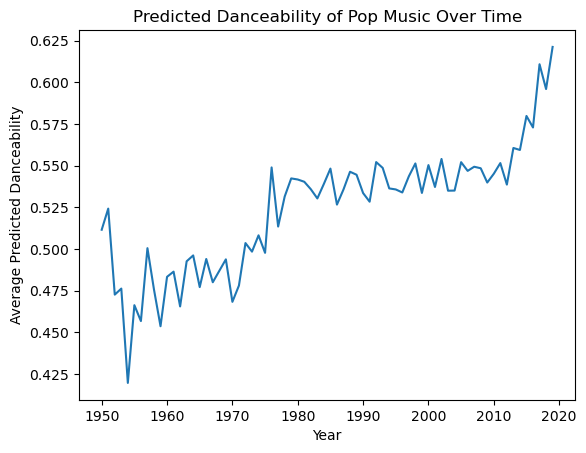

In [53]:
from matplotlib import pyplot as plt 

danceability_over_time = df.groupby('release_date')['danceability'].mean()
plt.plot(danceability_over_time.index, danceability_over_time.values)
plt.xlabel('Year')
plt.ylabel('Average Predicted Danceability')
plt.title('Predicted Danceability of Pop Music Over Time')
plt.show()

Looks like music started out fairly danceable, suffered a danceability crisis in the mid 50's and since then has been improving steadily, to reaching the current maximum of 62% in 2020.

          sadness    energy
genre                      
blues    0.113511  0.581534
country  0.165922  0.466350
hip hop  0.036589  0.703236
jazz     0.124067  0.463430
pop      0.142083  0.601097
reggae   0.078312  0.589931
rock     0.133539  0.700954


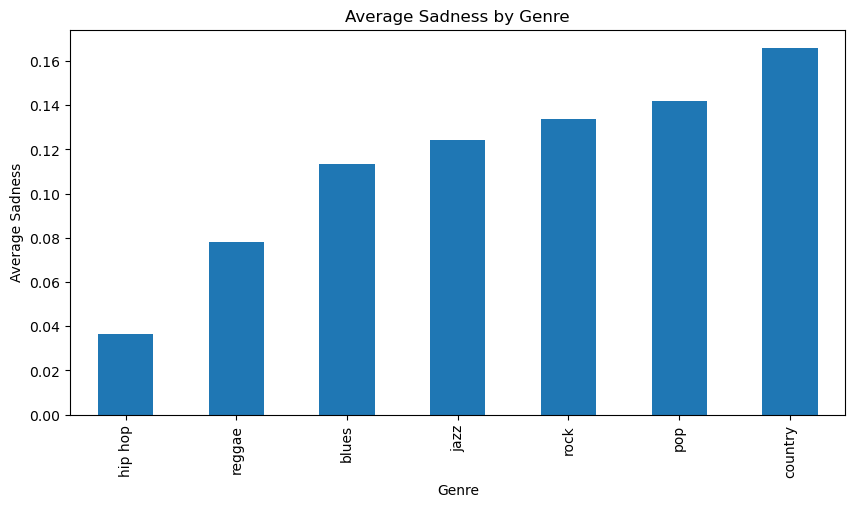

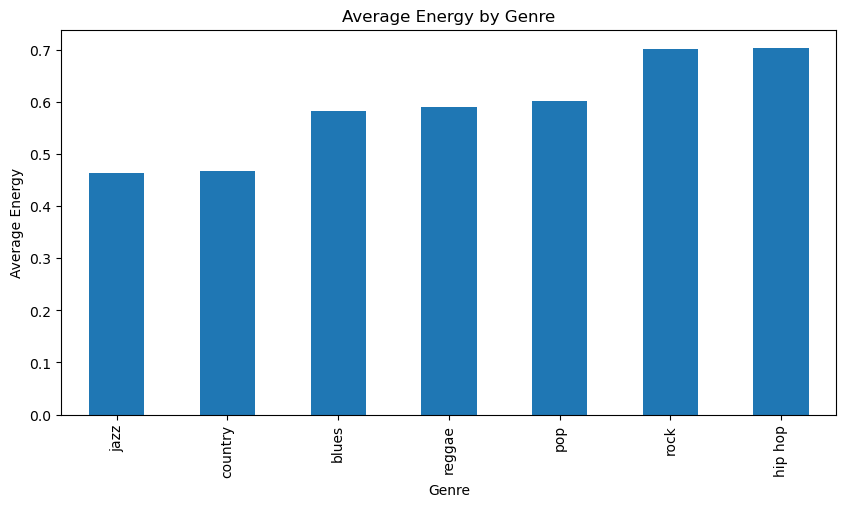

In [70]:
import matplotlib.pyplot as plt

reverse_genres = {v: k for k, v in genres.items()}
# Reverse the mapping in the 'genre' column
df['genre'] = df['genre'].map(reverse_genres)

genre_analysis = df.groupby('genre')[['sadness', 'energy']].mean()
print(genre_analysis)

# Plot average sadness scores
plt.figure(figsize=(10, 5))
genre_analysis['sadness'].sort_values().plot(kind='bar')
plt.xlabel('Genre')
plt.ylabel('Average Sadness')
plt.title('Average Sadness by Genre')
plt.show()

# Plot average energy scores
plt.figure(figsize=(10, 5))
genre_analysis['energy'].sort_values().plot(kind='bar')
plt.xlabel('Genre')
plt.ylabel('Average Energy')
plt.title('Average Energy by Genre')
plt.show()

Interestingly enough, blues is actually ranked on the lower end for sadness. Country takes the win on that one. For energy, rock and hip-hop at the upper end of the scale totally makes sense.

Well, that's the deep learning blog post! This was something I was really excited about learning since last winter when I wasn't able to take the deep learning course. I'm very pleased I've finally had the chance to learn a bit about it. I've certainly enjoyed the absolute time sink of watching the epochs go by with my fingers crossed. I was a bit surprised that the features model performed better on the validation set than the lyrics model did - spotify clearly knew what it was doing by calculating those features. It did make sense that the combined model slightly outperformed either individual model on both the training set and the validation set, as it combined learning from the lyrics and features model. Finally, to speak about the interesting figures above, I was honestly not so surprised that the danceability of music has been increasing (the youth is a little obsessed with dancing). However, I was surprised to see how low blues ranked in terms of sadness. Same with hip-hop; although it might not be sadness in a spotify ranked way, I feel like there are often pretty dark themes in hip-hop.

I definitely hope to learn more about deep learning in the future, and who knows, maybe one day I will finally make that deep learning model for chess.